In [2]:
import numpy as np

a = np.random.random([3, 3])

print(np.diag(a))
print(np.diag(np.diag(a)))

[0.46717064 0.54178708 0.40977153]
[[0.46717064 0.         0.        ]
 [0.         0.54178708 0.        ]
 [0.         0.         0.40977153]]


在 NumPy 中，多维数组（即 ndarray）的维度顺序通常是按从外到内的顺序排列的。例如，对于一个二维数组（矩阵），第一个维度代表行，第二个维度代表列。对于一个三维数组，维度顺序是深度、高度和宽度。

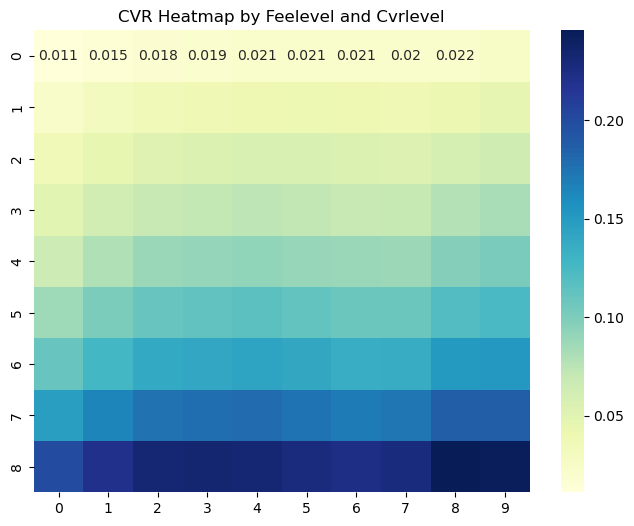

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 模拟数据
data = np.array([
    [0.0111, 0.0154, 0.0181, 0.0195, 0.0210, 0.0214, 0.0207, 0.0204, 0.0221, 0.0252],
    [0.0235, 0.0305, 0.0363, 0.0377, 0.0393, 0.0398, 0.0391, 0.0384, 0.0422, 0.0460],
    [0.0358, 0.0452, 0.0519, 0.0544, 0.0567, 0.0564, 0.0548, 0.0538, 0.0594, 0.0634],
    [0.0493, 0.0622, 0.0692, 0.0712, 0.0737, 0.0721, 0.0690, 0.0702, 0.0777, 0.0817],
    [0.0653, 0.0791, 0.0885, 0.0903, 0.0926, 0.0894, 0.0882, 0.0881, 0.0964, 0.1017],
    [0.0863, 0.1005, 0.1103, 0.1131, 0.1155, 0.1122, 0.1091, 0.1090, 0.1211, 0.1245],
    [0.1106, 0.1270, 0.1388, 0.1409, 0.1433, 0.1397, 0.1349, 0.1358, 0.1506, 0.1520],
    [0.1470, 0.1643, 0.1760, 0.1774, 0.1795, 0.1744, 0.1700, 0.1725, 0.1870, 0.1878],
    [0.2005, 0.2202, 0.2328, 0.2340, 0.2327, 0.2271, 0.2232, 0.2275, 0.2458, 0.2434]
])

# 创建热力图
plt.figure(figsize=(8, 6))
sns.heatmap(data, annot=True, cmap='YlGnBu')  # 'viridis' colormap
plt.title('CVR Heatmap by Feelevel and Cvrlevel')
plt.show()

In [5]:
# 导入相应的包
import numpy as np
tmp = np.zeros((4,))
print(tmp)

[0. 0. 0. 0.]


# 网络类型
1. FC 全连接层
2. CNN 卷积层
3. LayerNorm 层
4. BatchNorm 层

In [20]:
# 全连接层
"""
前向传播:
    - z = xW^T + b

反向传播: dz为batch_size * output_dim
    - dz/dW = dz^T * X, output_dim * input_dim
    - dz/db = sum(dz), output_dim
    - dz/dX = dz * W, batch_size * input_dim (对应上一层的输出)

复杂度分析:
    - 前向传播: O(batch_size, input_dim, output_dim)
    - 后向传播: O(batch_size, input_dim, output_dim)
"""
class FullConnectedLayer:

    def __init__(self, input_dim, output_dim, learning_rate=1e-2):
        
        # 初始化参数，randn是正太分布初始化
        self.W = np.random.randn(output_dim, input_dim)
        self.b = np.random.randn(output_dim)
        self.learning_rate = learning_rate

    
    def forward(self, x):

        # 全连接层计算 z = Wx + b
        # x: batch_size * input_dim 
        # 维度不同时，numpy会通过广播机制进行补齐
        self.input = x
        self.z = np.dot(x, self.W.T) + self.b 

        # 注意要保留计算结果，用于反向传播
        return self.z

    def backward(self, dz):

        # 计算梯度
        # dz : batch * output_dim
        dW = np.dot(dz.T, self.input)
        db = np.sum(dz, axis=0)
        dX = np.dot(dz, self.W)

        # 更新参数
        self.W -= self.lr * dW
        self.b -= self.lr * db

        return dX        

---

# 激活函数
1. ReLU 激活函数
2. Sigmoid 激活函数
3. Softmax 激活函数

In [ ]:
# ReLU 激活函数 
"""
前向传播
    - output = max(X, 0)

反向传播
    - dz/dX = dz * (X > 0)

复杂度分析
    - 前向传播: O(batch_size, input_dim)
    - 后向传播: O(batch_size, input_dim)
"""
class ReLULayer:

    def __init__(self):
        pass

    def forward(self, x):


        self.x = x
        self.output = np.maximum(self.x, 0)

        return self.output
    
    def backward(self, doutput):

        dz = doutput * (self.input > 0).astype(float)
        return dz

---

# 损失函数
1. MSE 损失函数
2. MAE 损失函数

In [18]:
# MSE 损失函数
"""
前向传播:
    - output = 1/N * sum(y_pred - y_true)

反向传播:
    - dL/dX = 2/batch_size * (y_pred - y_true)

复杂度分析:
    - 前向传播: O(batch_size, input_dim)
    - 后向传播: O(batch_size, input_dim)
"""
class MSELoss:
    
    def __init__(self):
        pass
    
    def forward(self, y_pred, y_true):
        
        # 计算loss
        self.y_pred = y_pred
        self.y_true = y_true

        loss = np.mean((y_pred - y_true) ** 2)

        return loss
    
    def backward(self):

        # 计算梯度
        # dL: batch_size * output*dim
        batch_size = self.y_pred.shape[0]
        dL = (2 * (self.y_pred - self.y_true)) / batch_size

        return dL

In [25]:
# 测试
fc_layer = FullConnectedLayer(input_dim=5, output_dim=1)
loss_function = MSELoss()

# 输入和目标
X = np.array([[1, 2, 3, 4, 5], 
              [5, 4, 3, 2, 1], 
              [1, 3, 5, 2, 4]])
y = np.array([[1], 
              [0], 
              [1]])

print(np.sum(X, axis=0))
print(np.sum(X, axis=1))
aaaa

print(X.shape)
print(y.shape)

# 前向传播
z = fc_layer.forward(X)
loss = loss_function.forward(z, y)

# 反向传播
dz = loss_function.backward()
dx = fc_layer.backward(dz)

# print(dz.shape)
# print(dz)

# print("Loss:", loss)
# print("Gradient wrt Input:", dx)

[ 7  9 11  8 10]
[15 15 15]


NameError: name 'aaaa' is not defined